* 문제 출처: 해커랭크
https://www.hackerrank.com/challenges/challenges/problem

## Challenges

In [11]:
from IPython.display import Image
import pandas as pd

### 1) Table 구조

Hackers Table

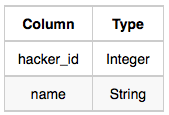

In [9]:
Image('http://s3.amazonaws.com/hr-challenge-images/19506/1458521004-cb4c077dd3-ScreenShot2016-03-21at6.06.54AM.png')

Challenges Table

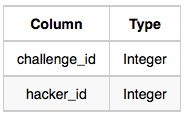

In [10]:
Image('http://s3.amazonaws.com/hr-challenge-images/19506/1458521079-549341d9ec-ScreenShot2016-03-21at6.07.03AM.png')

### 2) 문제 설명
- Julia가 Hackers 테이블에 있는 학생들에게 Challenge를 만들어 달라고 부탁하여 위의 테이블 2개가 구성됨
- hacker_id 별로 만든 challenge의 합계를 구하고 싶음 

[조건]
1. hacker_id, name, total number of challenges 보여줄 것
2. 집계한 challenge가 큰 순서대로 정렬할 것 (동일할 경우 hacker_id 오름차순)
3. 만약 total number of challenges 가 중복일 경우 결과에서 제외해줄 것 
4. 만약 total number of challenges 가 max값일 경우 중복이어도 결과에 포함할 것 


문제가 복잡해보이는데, sample 예제 2개를 손으로 하나하나 그려보면 이해에 도움이 된다.

### 3) Sample 로 결과 테이블 뽑아보기

hackers와 challenges 테이블이 아래와 같이 각각 주어졌을 때, 결과값이 어떻게 
나올지 그려보면서 문제를 이해해 보자

In [21]:
hackers_dict={
    'hacker_id':[5077,21283,62743,88255,96196],
    'name':['Rose','Angela','Frank','Patrick','Lisa']
}

In [38]:
challenges_dict={
    'challenge_id':[61654,58302,40587,29477,1220,69514,46561,58077,18483
                   ,76766,52382,74467,33625,26053,42665,12859,70094,34599,
                   54680,61881,61882],
    'hacker_id':[5077,21283,88255,5077,21283,21283,62743,62743,88255,
                21283,5077,21283,96196,88255,62743,62743,21283,88255
                 ,88255,5077,88255]
}

Hacker Table

In [39]:
hackers=pd.DataFrame(hackers_dict)
hackers

,hacker_id,name
0,5077,Rose
1,21283,Angela
2,62743,Frank
3,88255,Patrick
4,96196,Lisa


Challenge Table

In [40]:
challenges=pd.DataFrame(challenges_dict)
challenges

,challenge_id,hacker_id
0,61654,5077
1,58302,21283
2,40587,88255
3,29477,5077
4,1220,21283
5,69514,21283
6,46561,62743
7,58077,62743
8,18483,88255
9,76766,21283


- hackers 테이블과 challenges 테이블을 조인하여, 각각의 학생이 몇개의 challenge를 만들었는지 집계한다.

In [41]:
joined=hackers.merge(challenges,how='left',on='hacker_id').groupby(['hacker_id','name'])['challenge_id'].count()
joined

hacker_id  name   
5077       Rose       4
21283      Angela     6
62743      Frank      4
88255      Patrick    6
96196      Lisa       1
Name: challenge_id, dtype: int64

### [결과 추출]
1. 집계 결과 큰 순서대로 정렬
2. 중복된 결과 제거 (max 아닐 경우에만)

In [42]:
result_dict={
   
    'hacker_id':[21283,88255,96196],
    'name':['Angela','Patrick','Lisa'],
    'count' :[6,6,1]
}
results=pd.DataFrame(result_dict)
results

,hacker_id,name,count
0,21283,Angela,6
1,88255,Patrick,6
2,96196,Lisa,1


- 집계 결과가 4로 동일한 Rose,Frank 의 결과는 제외했으며 집계수가 큰 대로 정렬되었다.
- Angela 와 Patrict도 집계수가 6으로 동일하지만, Max 값이므로 중복이어도 살려둔다

### 4) SQL 로 풀기

1단계: Base 코드 만들기

문제가 복잡하기 때문에 처음부터 다 짜려고 하면 머리아프다.
조건 포함되기 전 베이스 코드를 먼저 짜보자.

- 각 학생이 생성한 challenge 수 집계 (Join + Group by + COUNT())
- 정렬 조건 넣어주기 (Order by)

```sql
SELECT H.hacker_id, H.name, count(C.challenge_id) as c_num
FROM Hackers H
    LEFT JOIN Challenges C
    ON H.hacker_id = C.hacker_id
GROUP BY 1,2
ORDER BY c_num DESC, hacker_id ASC
```

2단계: HAVING 절에 Sub 쿼리 사용해서 조건문 추가하기

- 조건1.c_num 이 MAX 값일 경우엔 중복이어도 제외하지 않음 

-> c_num이 MAX 인 ROW 추가

- 조건2.c_num 이 MAX 값이 아닐경우 중복값을 가지는 Row 제외

-> count(c_num) = 1 인 ROW 추가

```sql
SELECT H.hacker_id, H.name, count(C.challenge_id) as c_num
FROM Hackers H
    LEFT JOIN Challenges C
    ON H.hacker_id = C.hacker_id
GROUP BY 1,2
HAVING c_num = (SELECT max(num) -- 조건1
                FROM(
					 SELECT hacker_id
							, count(*) as num
					 FROM challenges
                     GROUP BY hacker_id
					) AS sub
				)
OR c_num IN (SELECT c_num -- 조건 2
			 FROM(
				  SELECT hacker_id
                         ,count(*) as c_num
				  FROM Challenges
				  GROUP BY hacker_id
				  ) as T
			  GROUP BY 1
			  HAVING count(*) = 1
			  )
ORDER BY c_num DESC, hacker_id ASC

```

특히 조건2가 까다로웠는데, c_num을 카운트하기 위해서 hackers 와 challenges 테이블을 조인해줄 필요 없으며, From 절에서 sub쿼리를 통해 아이디 별 c_num 수를 구하고, 바깥에서 Group by 와 having 을 통해 c_num이 1인 것만 뽑아낼 수 있었다.